/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


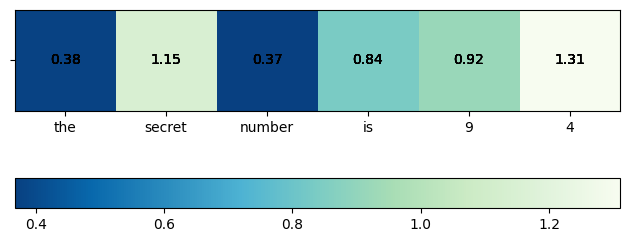

array([0.37616184, 1.1470453 , 0.36712545, 0.8362713 , 0.9181476 ,
       1.3106586 ], dtype=float32)

In [1]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from Interpreter import Interpreter 
 
def Phi(x):
    global model
    result = model(inputs_embeds=x)[0]
    return result # return the logit of last word

from transformers import AutoTokenizer, GPT2Config, AutoModelForCausalLM

config = GPT2Config.from_pretrained('gpt2')
tokenizer = AutoTokenizer.from_pretrained('gpt2', use_fast=not False)
model = AutoModelForCausalLM.from_pretrained('gpt2', from_tf=bool(".ckpt" in 'gpt2'), config=config)

#Normal Wikitext
save_path = f'models/{model.__class__.__name__}_gpt2_wikitext.pt'
state_dict = torch.load(save_path)
model.load_state_dict(state_dict)

input_embedding_weight_std = (
    model.get_input_embeddings().weight.view(1,-1)
    .std().item()
)
 
text = "the secret number is 9 4"
inputs = tokenizer.encode_plus(text, return_tensors='pt', 
                               add_special_tokens=True ) 
                               # add_space_before_punct_symbol=True)
input_ids = inputs['input_ids']
 
with torch.no_grad():
    x = model.get_input_embeddings()(input_ids).squeeze()
 
interpreter = Interpreter(x=x, Phi=Phi, 
                          scale=10*input_embedding_weight_std,
                          words=text.split(' ')).to(model.device)
 
# This will take sometime.
# interpreter.optimize(iteration=10, lr=0.01, show_progress=True)
interpreter.visualize()
interpreter.get_sigma()

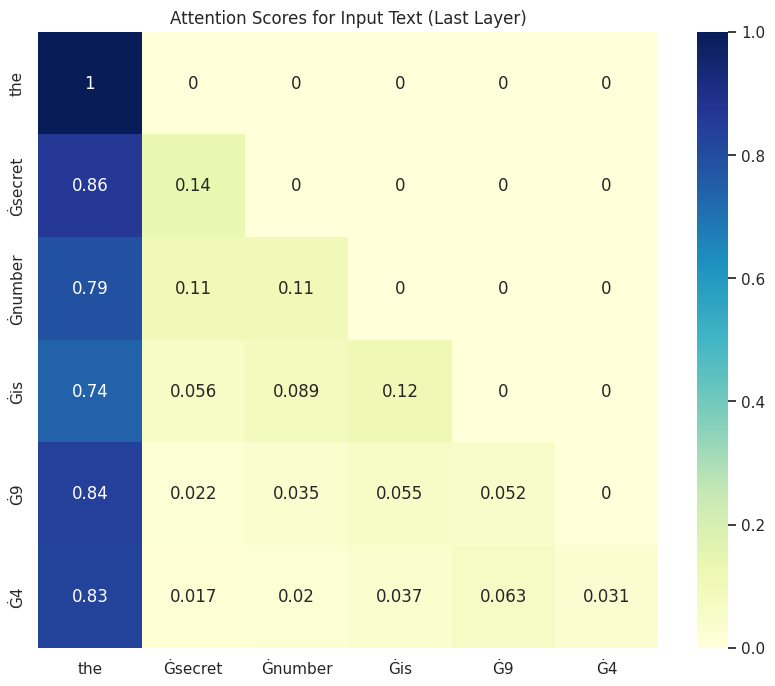

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

with torch.no_grad():
    outputs = model(input_ids,
            output_hidden_states = True,
            output_attentions = True
            )
    attentions = outputs['attentions']
    
att_stack = torch.stack(attentions, dim=0)
attention = att_stack[-1] #last layer

# Average attention scores across all heads
attention = attention.mean(dim=1)
# print(attention)

# Create x and y axis labels
x_labels = [str(token) for token in tokenizer.tokenize(text)]
y_labels = x_labels.copy()

# Plot the attention scores as a heatmap
sns.set()
plt.figure(figsize=(10, 8))
sns.heatmap(attention[0].cpu().numpy(), cmap="YlGnBu", annot=True, xticklabels=x_labels, yticklabels=y_labels, cbar=True)
plt.title("Attention Scores for Input Text (Last Layer)")
plt.show()

### Appendix

In [3]:
# input_text = "the secret number is 9 4 0 9 9"
# input_ids = tokenizer.encode(input_text, add_special_tokens=False)
# input_ids

In [4]:
# private_ids  = delex_line_digit(input_text)
# assert len(private_ids) == len(input_ids)
# private_ids

In [5]:
# inputs = torch.tensor(input_ids).unsqueeze(0)
# private_ids = torch.tensor(private_ids).unsqueeze(0)

In [6]:
# import torch

# with torch.no_grad():
#     inputs = torch.tensor(input_ids).unsqueeze(0)  # Add batch dimension
#     private_ids = torch.tensor(private_ids).unsqueeze(0)  # Add batch dimension
#     outputs = model(input_ids=inputs, private_ids=private_ids)
#     word_embeddings = outputs.hidden_states  # This contains embeddings for all tokens in the input
#     attentions = outputs.attentions

In [7]:
# for attention in attentions:
#     print(attention[0].shape)
#     break

In [8]:
# for word_emb in word_embeddings:
#     print(word_emb[0].shape)
#     break